# Image Segmentation
### This Notebook demonstrates how the CelebAMask dataset can be used to fuse a hairstyle on to a different person
##### https://github.com/switchablenorms/CelebAMask-HQ
I created a smaller folder containing just 30 images and and a folder containg its corresponding masks

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import math

In [2]:
blacklist_hairstyle= [1486]

In [3]:
with open('../CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt') as f:
    lines = f.readlines()
    

In [4]:
columns = ['image_name','drop','5_o_Clock_Shadow','Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs',
           'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
           'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
           'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
           'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 
           'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
attributes = pd.read_csv('../CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt',skiprows=[0,1], sep=' ',names= columns, header=None)
attributes.drop('drop', axis=1,inplace=True)
attributes

,image_name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0.jpg,-1,1,1,1,-1,-1,1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
1,1.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
2,2.jpg,-1,-1,1,1,-1,-1,1,-1,-1,...,-1,1,-1,1,1,-1,1,-1,-1,1
3,3.jpg,-1,-1,1,-1,-1,-1,-1,1,1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
4,4.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995.jpg,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,1,-1,-1
29996,29996.jpg,1,-1,-1,1,-1,-1,-1,1,-1,...,1,1,-1,-1,-1,-1,-1,-1,-1,1
29997,29997.jpg,-1,-1,-1,-1,-1,1,-1,-1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
29998,29998.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


In [5]:
attributes['Wearing_Hat'].value_counts()

-1    28930
 1     1070
Name: Wearing_Hat, dtype: int64

### Get all faces that look straight at the camera

### fuse pose and image attributes

In [6]:
columns = ['image_name','Yaw','Pitch','Raw']
pose = pd.read_csv('../CelebAMask-HQ/CelebAMask-HQ-pose-anno.txt',skiprows=[0,1], sep=' ',names= columns, header=None)
#pose.drop('drop', axis=1,inplace=True)
pose[pose["Yaw"]<abs(5)]
data_straight = pose[(abs(pose['Yaw']) < 5) & (abs(pose['Pitch']) < 5) & (abs(pose['Raw']) < 5)]
data_straight
#plt.scatter(pose["Yaw"],pose["Pitch"])

,image_name,Yaw,Pitch,Raw
15,15.jpg,4.738663,-4.512314,-0.144493
31,31.jpg,2.470963,2.043396,-0.192787
35,35.jpg,-0.353325,-1.079887,1.445816
57,57.jpg,0.090805,-1.680588,1.779587
76,76.jpg,2.466019,-1.397171,1.315727
...,...,...,...,...
29967,29967.jpg,4.066154,0.663956,-1.773636
29970,29970.jpg,4.294647,-2.834167,-0.480446
29982,29982.jpg,2.493683,-0.397705,-0.297386
29995,29995.jpg,0.108932,-0.664413,0.135849


In [7]:
data_all  = pd.concat([pose, attributes.drop('image_name', axis=1)], axis=1)
data_all

,image_name,Yaw,Pitch,Raw,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0.jpg,-16.761650,-3.540695,-0.468292,-1,1,1,1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
1,1.jpg,8.853630,-16.055931,-1.150886,-1,1,1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
2,2.jpg,35.265182,-6.890411,-1.581253,-1,-1,1,1,-1,-1,...,-1,1,-1,1,1,-1,1,-1,-1,1
3,3.jpg,-16.793152,1.010948,0.133667,-1,-1,1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
4,4.jpg,5.474228,-12.340668,-0.894409,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995.jpg,0.108932,-0.664413,0.135849,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,1,-1,-1
29996,29996.jpg,4.065002,-1.689423,-1.262672,1,-1,-1,1,-1,-1,...,1,1,-1,-1,-1,-1,-1,-1,-1,1
29997,29997.jpg,5.378021,-12.933311,1.843475,-1,-1,-1,-1,-1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
29998,29998.jpg,16.967903,-6.059593,-3.954010,-1,1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


#### Remove hats etc.

In [8]:
data_nohat=data_all[data_all["Wearing_Hat"]==-1]
data_nohat

,image_name,Yaw,Pitch,Raw,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0.jpg,-16.761650,-3.540695,-0.468292,-1,1,1,1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
1,1.jpg,8.853630,-16.055931,-1.150886,-1,1,1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
2,2.jpg,35.265182,-6.890411,-1.581253,-1,-1,1,1,-1,-1,...,-1,1,-1,1,1,-1,1,-1,-1,1
3,3.jpg,-16.793152,1.010948,0.133667,-1,-1,1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
4,4.jpg,5.474228,-12.340668,-0.894409,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995.jpg,0.108932,-0.664413,0.135849,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,1,-1,-1
29996,29996.jpg,4.065002,-1.689423,-1.262672,1,-1,-1,1,-1,-1,...,1,1,-1,-1,-1,-1,-1,-1,-1,1
29997,29997.jpg,5.378021,-12.933311,1.843475,-1,-1,-1,-1,-1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
29998,29998.jpg,16.967903,-6.059593,-3.954010,-1,1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


No hat + Straight + Feale

In [9]:
dataset1=data_all[(abs(data_all['Yaw']) < 5) & 
                     (abs(data_all['Pitch']) < 5) & 
                     (abs(data_all['Raw']) < 5) &
                     (data_all["Wearing_Hat"] == -1) &
                     (data_all["Male"] == 1)&
                     (data_all["Attractive"]== 1)]
dataset1

,image_name,Yaw,Pitch,Raw,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
264,264.jpg,-3.438927,-2.365791,-0.218384,1,-1,1,-1,-1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
317,317.jpg,3.630768,-3.403198,-0.472435,1,1,1,-1,-1,1,...,1,1,-1,1,-1,-1,-1,-1,-1,1
554,554.jpg,-3.718903,-1.926529,0.410110,1,-1,1,-1,-1,1,...,-1,-1,-1,1,-1,-1,-1,-1,1,1
588,588.jpg,2.448639,-4.824760,0.278481,1,-1,1,1,-1,-1,...,1,1,-1,-1,-1,-1,-1,-1,-1,1
823,823.jpg,1.358505,-2.983597,0.495346,1,-1,1,1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29712,29712.jpg,1.063156,-0.012016,-0.576096,1,-1,1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,1,1
29735,29735.jpg,1.356140,-1.614380,-0.266212,1,-1,1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
29820,29820.jpg,1.634537,0.163406,0.520355,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
29848,29848.jpg,-2.594124,-1.403061,0.236252,1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1


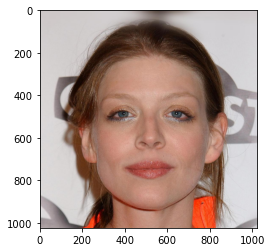

In [10]:
i = 322
# load style image
path_style = '../CelebAMask-HQ/CelebA-HQ-img/'+str(i)+'.jpg'

image_style = cv2.imread(path_style)
image_style = cv2.cvtColor(image_style, cv2.COLOR_RGB2BGR)

plt.imshow(image_style)


Get all the features that are available in the dataset

In [11]:
from os import listdir
from os.path import isfile, join
filenames = [f for f in listdir('../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0') if isfile(join('../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0', f))]
features = set([w[5:] for w in filenames])
print(features)

{'_eye_g.png', '_neck.png', '_hat.png', '_r_ear.png', '_ear_r.png', '_r_brow.png', '_u_lip.png', '_l_ear.png', '_r_eye.png', 'mage.png', '_cloth.png', '_nose.png', '_mouth.png', '_l_eye.png', '_skin.png', '_neck_l.png', '_l_brow.png', '_l_lip.png', '_hair.png'}


In [15]:
masks = {
         '_l_brow.png', '_l_lip.png', '_mouth.png', '_nose.png', 
         '_r_eye.png', '_r_brow.png',
         '_u_lip.png', '_l_eye.png', 
         '_r_ear.png', '_l_ear.png', #ears
         #'_ear_r.png', # earrings
         '_neck_l.png', # necklace
         #'_hat.png', # hat
         '_neck.png' # neck
         #'_hair.png', # hair
         #'_cloth.png', # clothes
         #'_eye_g.png' # glasses
         #'_skin.png',
        }
i = 322
i=317
path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(i).zfill(5)+'_skin.png'
if os.path.isfile(path_mask):
    mask_total = cv2.imread(path_mask,0)
for feature in masks:
    path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(i).zfill(5)+feature
    if os.path.isfile(path_mask):
        mask_add = cv2.imread(path_mask,0)
    mask_total = cv2.add(mask_total,mask_add)
mask=np.where(mask_total == 0, mask_total, 255)
plt.imshow(mask)


NameError: name 'mask_add' is not defined

NameError: name 'mask' is not defined

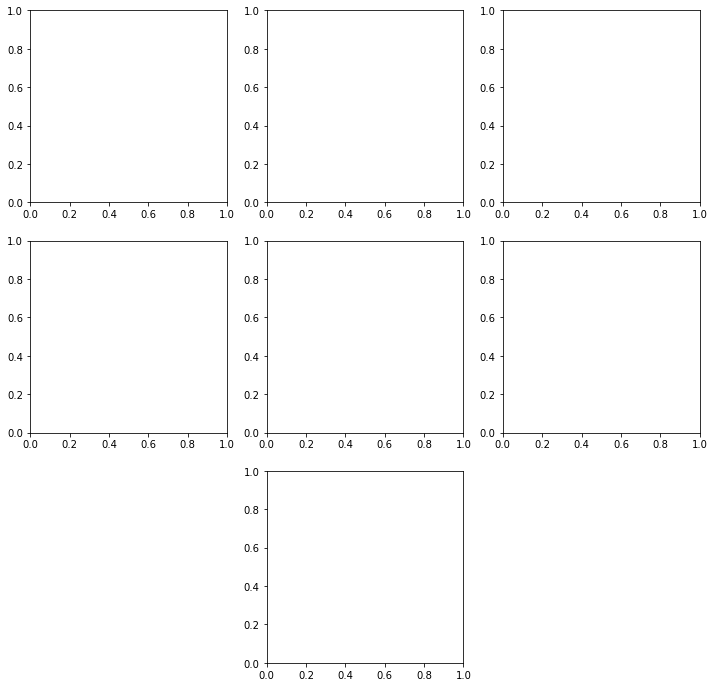

In [14]:
i= 322
i=281
path_upload = '../CelebAMask-HQ/CelebA-HQ-img/'+str(i)+'.jpg'

image_upload = cv2.imread(path_upload)
image_upload = cv2.cvtColor(image_upload, cv2.COLOR_RGB2BGR)
image_upload = cv2.resize(image_upload, (0,0), fx=0.5, fy=0.5)

j = 35
j=317
# load 'uploaded' image
path_stlye = '../CelebAMask-HQ/CelebA-HQ-img/'+str(j)+'.jpg'
image = cv2.imread(path_stlye)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 
# load mask hair
path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(j).zfill(5)+'_hair.png'
mask_style = cv2.imread(path_mask,0)

fig, axs = plt.subplots(3, 3,figsize=(12,12))
fig.delaxes(axs[2,0])
fig.delaxes(axs[2,2])

face = cv2.bitwise_and(image_upload,image_upload,mask = mask)
style = cv2.bitwise_and(image,image,mask = mask_style)

# combine the two masked images
face_minus = cv2.bitwise_and(face, face, mask=255-mask_style)
result = cv2.add(style, face_minus)
result[result[:,:,2]==0]=255


axs[0,0].imshow(image_upload)
axs[0,1].imshow(mask)
axs[0,2].imshow(face)
axs[1,0].imshow(image)
axs[1,1].imshow(mask_style)
axs[1,2].imshow(style)
axs[2,1].imshow(result)


### Get hairstyle that are not cropped

<ipython-input-16-546a16b4df75>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2,figsize=(4,4))


(82, 512, 512, 3)

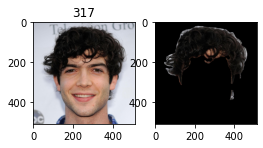

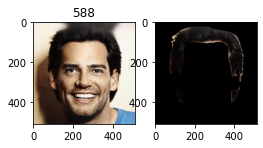

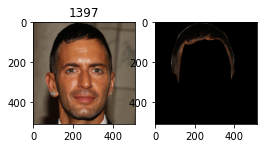

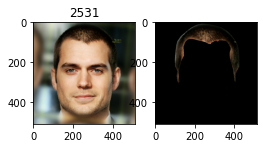

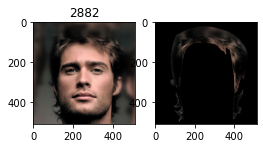

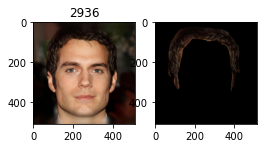

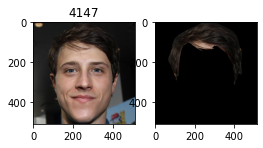

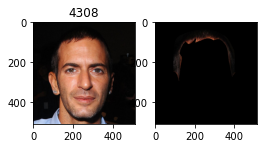

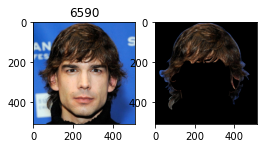

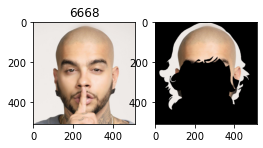

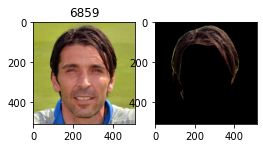

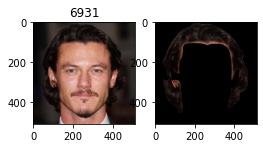

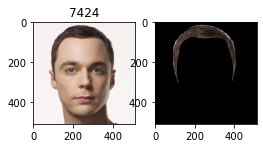

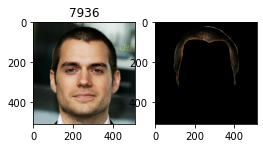

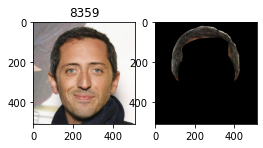

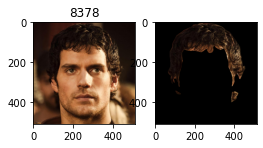

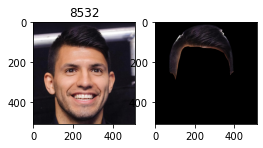

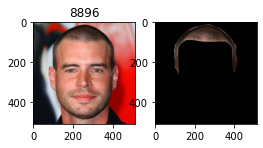

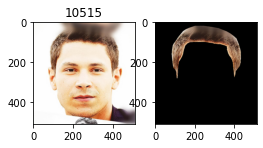

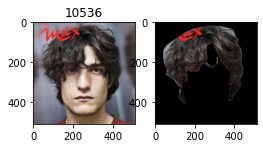

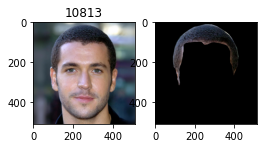

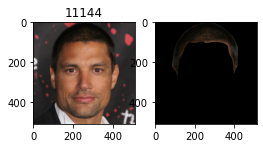

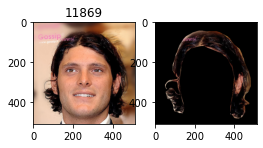

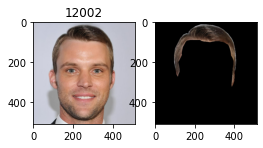

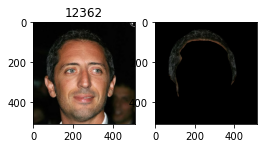

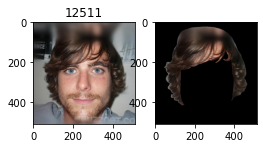

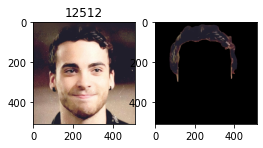

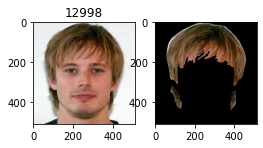

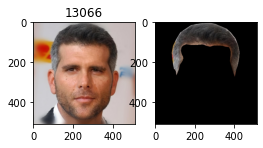

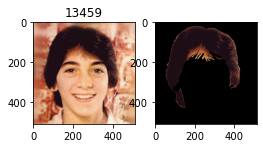

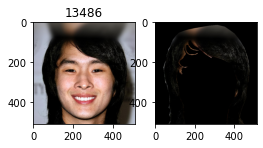

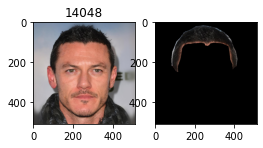

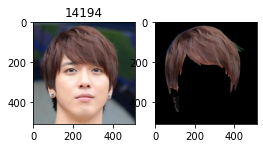

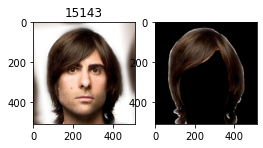

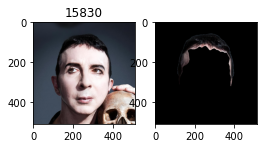

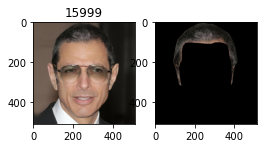

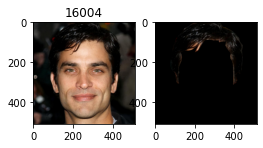

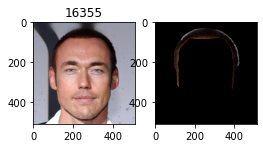

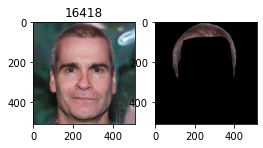

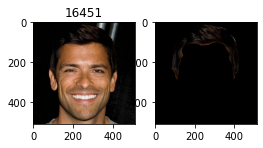

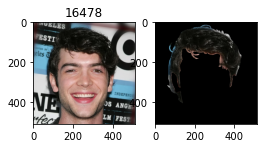

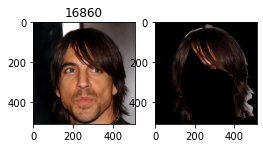

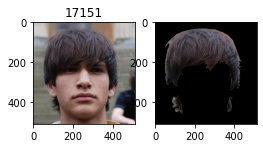

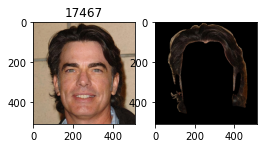

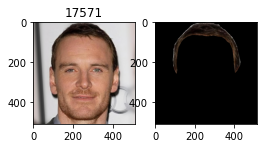

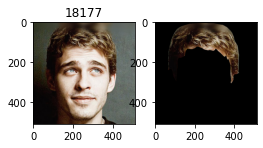

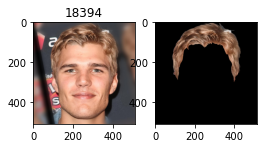

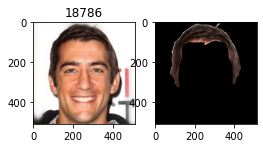

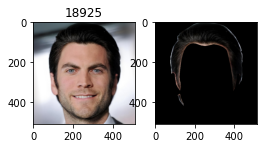

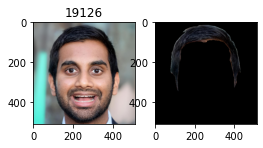

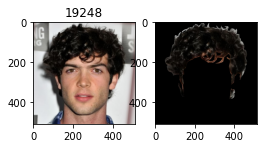

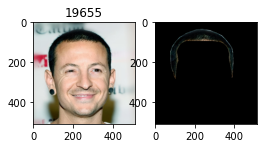

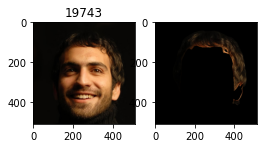

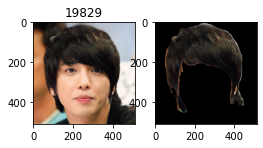

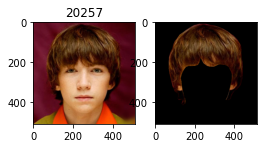

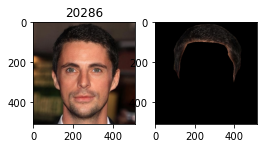

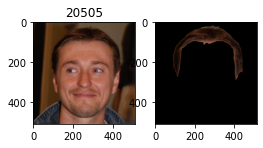

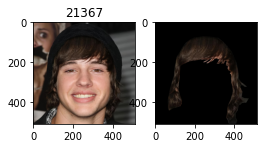

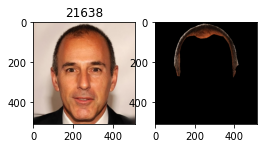

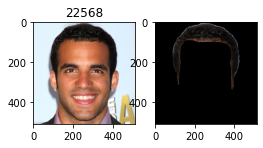

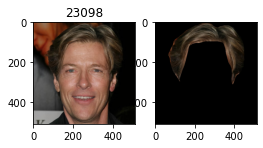

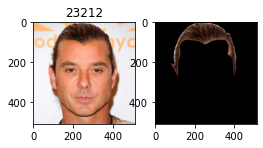

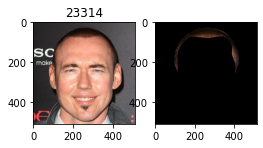

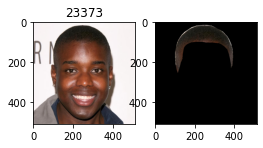

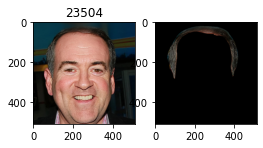

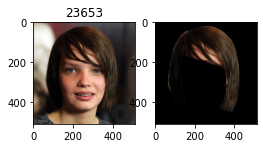

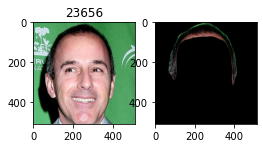

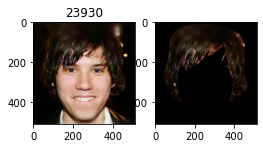

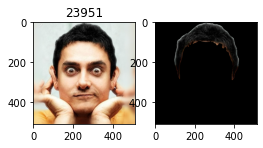

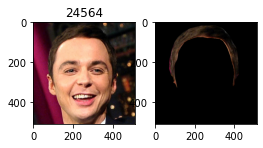

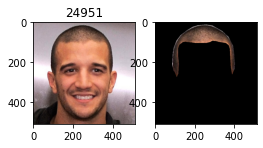

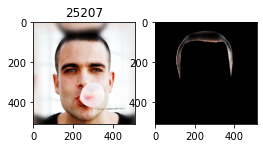

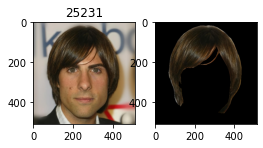

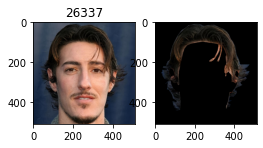

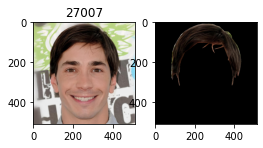

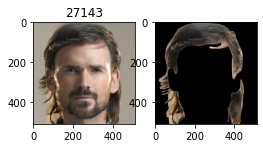

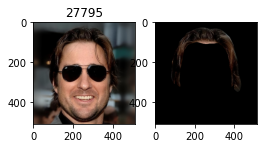

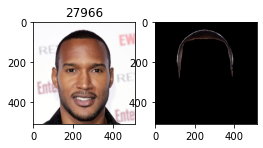

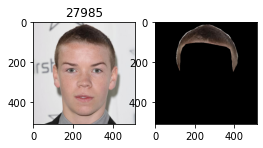

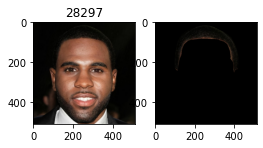

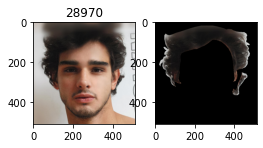

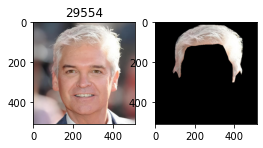

In [16]:
non_cropped = []
hairstyles = []
for i in dataset1.index:
    j = math.trunc(i/2000)
    hair_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/'+str(j)+'/'+str(i).zfill(5)+'_hair.png'
    if os.path.isfile(hair_mask):
        mask = cv2.imread(hair_mask,0)
        is_all_zero_up = np.all((mask[0,:] == 0))
        is_all_zero_left = np.all((mask[:,0] == 0))
        is_all_zero_right = np.all((mask[:,-1] == 0))
        
    if is_all_zero_up & is_all_zero_left & is_all_zero_right:
        path = '../CelebAMask-HQ/CelebA-HQ-img/'+str(i)+'.jpg'
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 

        hairstyle = cv2.bitwise_and(image,image,mask = mask)
        
        fig, axs = plt.subplots(1, 2,figsize=(4,4))
        axs[0].title.set_text(i)
        axs[0].imshow(image)
        axs[1].imshow(hairstyle)
        non_cropped.append(i)
        hairstyles.append(hairstyle)
        
hairstyles = np.array(hairstyles)
        
#img_num = 400


#test_X = X.flatten('F').reshape((img_num,-1),order='F')
#print("flatten done")
#print(test_X.shape)
#np.save('data_X.npy', test_X)
#print("save as .npy done")        
hairstyles.shape
#print(non_cropped)



### Train neural networks

### get skin mask

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.io.parsers import read_csv
from skimage.color import rgb2gray
from tensorflow import keras 
import os

In [120]:
import numpy as np
import random
import cv2

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output


In [10]:
#Load masks
indx = []
y = []
for i in range(2000):
    print(i)
    masks = {
         #'_l_brow.png', '_l_lip.png', '_mouth.png', '_nose.png', 
         #'_r_eye.png', '_r_brow.png',
         #'_u_lip.png', '_l_eye.png', 
         #'_r_ear.png', '_l_ear.png', #ears
         #'_ear_r.png', # earrings
         #'_neck_l.png', # necklace
         #'_hat.png', # hat
         #'_neck.png' # neck
         #'_hair.png', # hair
         #'_cloth.png', # clothes
         #'_eye_g.png' # glasses
         '_skin.png',
        }
    indx.append(i)
    mask_total=[]
    path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(i).zfill(5)+'_skin.png'
    if os.path.isfile(path_mask):
        mask_total = cv2.imread(path_mask)
        mask_total = cv2.resize(mask_total, (128,128))

    for feature in masks:
        path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(i).zfill(5)+feature
        if os.path.isfile(path_mask):
            mask_add = cv2.imread(path_mask)
            mask_add = cv2.resize(mask_add, (128,128))

        mask_total = cv2.add(mask_total,mask_add)
        mask=np.where(mask_total == 0, mask_total, 255)
        mask =   rgb2gray(mask)
    #mask = mask.flatten()
    y.append(mask)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
101
101
102
102
103
103
104
104
105
105
106
106
107
107
108
108
109
109
110
110
111
111
112
112
113
113
114
114
115
115
116
116
117
117
118
118
119
119
120
120
121
121
122
122
123
123
124
124
125
125
126
126
127
127
128
128
129
129
130
130
131
131
132
132
133
133
134
134
135
135
136
136
137
137
138
138
139
139
140
140
141
141
142
142
143
143
144
144
145
145
146
146
147
147
148
148
149
149
150
150
151
151
152


1045
1045
1046
1046
1047
1047
1048
1048
1049
1049
1050
1050
1051
1051
1052
1052
1053
1053
1054
1054
1055
1055
1056
1056
1057
1057
1058
1058
1059
1059
1060
1060
1061
1061
1062
1062
1063
1063
1064
1064
1065
1065
1066
1066
1067
1067
1068
1068
1069
1069
1070
1070
1071
1071
1072
1072
1073
1073
1074
1074
1075
1075
1076
1076
1077
1077
1078
1078
1079
1079
1080
1080
1081
1081
1082
1082
1083
1083
1084
1084
1085
1085
1086
1086
1087
1087
1088
1088
1089
1089
1090
1090
1091
1091
1092
1092
1093
1093
1094
1094
1095
1095
1096
1096
1097
1097
1098
1098
1099
1099
1100
1100
1101
1101
1102
1102
1103
1103
1104
1104
1105
1105
1106
1106
1107
1107
1108
1108
1109
1109
1110
1110
1111
1111
1112
1112
1113
1113
1114
1114
1115
1115
1116
1116
1117
1117
1118
1118
1119
1119
1120
1120
1121
1121
1122
1122
1123
1123
1124
1124
1125
1125
1126
1126
1127
1127
1128
1128
1129
1129
1130
1130
1131
1131
1132
1132
1133
1133
1134
1134
1135
1135
1136
1136
1137
1137
1138
1138
1139
1139
1140
1140
1141
1141
1142
1142
1143
1143
1144
1144


1875
1876
1876
1877
1877
1878
1878
1879
1879
1880
1880
1881
1881
1882
1882
1883
1883
1884
1884
1885
1885
1886
1886
1887
1887
1888
1888
1889
1889
1890
1890
1891
1891
1892
1892
1893
1893
1894
1894
1895
1895
1896
1896
1897
1897
1898
1898
1899
1899
1900
1900
1901
1901
1902
1902
1903
1903
1904
1904
1905
1905
1906
1906
1907
1907
1908
1908
1909
1909
1910
1910
1911
1911
1912
1912
1913
1913
1914
1914
1915
1915
1916
1916
1917
1917
1918
1918
1919
1919
1920
1920
1921
1921
1922
1922
1923
1923
1924
1924
1925
1925
1926
1926
1927
1927
1928
1928
1929
1929
1930
1930
1931
1931
1932
1932
1933
1933
1934
1934
1935
1935
1936
1936
1937
1937
1938
1938
1939
1939
1940
1940
1941
1941
1942
1942
1943
1943
1944
1944
1945
1945
1946
1946
1947
1947
1948
1948
1949
1949
1950
1950
1951
1951
1952
1952
1953
1953
1954
1954
1955
1955
1956
1956
1957
1957
1958
1958
1959
1959
1960
1960
1961
1961
1962
1962
1963
1963
1964
1964
1965
1965
1966
1966
1967
1967
1968
1968
1969
1969
1970
1970
1971
1971
1972
1972
1973
1973
1974
1974
1975


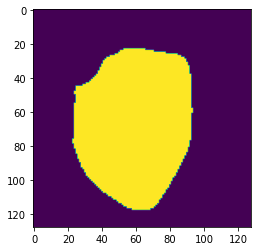

In [11]:
#maskEx = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
#maskEx = cv2.resize(maskEx, (96,96))
plt.figure(figsize=(4,4))
plt.imshow(y[56])
plt.show()


In [134]:
#Load Images
X = []
for i in range(len(indx)):
    print(i)
    path_image = '../CelebAMask-HQ/CelebA-HQ-img/'+str(indx[i])+'.jpg'
    img = cv2.imread(path_image,0)
    #img = rgb2gray(img)
    noise_img = sp_noise(img,0.05)
    noise_img = cv2.resize(noise_img, (128,128))

    #img = img.flatten()
    X.append(noise_img)

0
1
2
3
4
5
6
7
8


KeyboardInterrupt: 

In [ ]:
X = np.array(X)

In [13]:
print(np.array(X).shape)
print(np.array(y).shape)
X = np.array(X)
y = np.array(y)

(2000, 128, 128)
(2000, 128, 128)


In [ ]:
plt.imshow(X[55])


### Save and load of image array as npy file in order to use in collab

In [15]:
X.shape

(2000, 128, 128)

In [23]:
#number of images to be saved
img_num = 2000


test_X = X.flatten('F').reshape((img_num,-1),order='F')
print("flatten done")
print(test_X.shape)
np.save('data_X.npy', test_X)
print("save as .npy done")
test_X = np.load('data_X.npy')
print("load csv done")
test_X = test_X.reshape((img_num,512,512,3), order='F')
print("reshaping done")

print(test_X.shape)

ValueError: cannot reshape array of size 13107200 into shape (2000,newaxis)

In [ ]:
test_y = y.flatten('F').reshape((img_num,-1),order='F')
print("flatten done")
print(test_y.shape)
np.save('data_y.npy', test_y)
print("save as .npy done")
test_y = np.load('data_y.npy')
print("load csv done")
test_y = test_y.reshape((img_num,512,512), order='F')
print("reshaping done")

print(test_y.shape)


### Train face segementation model

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
#X_train = np.expand_dims(X_train, -1)

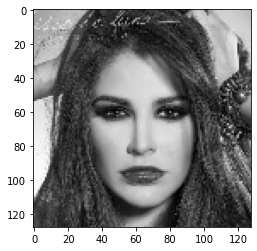

In [17]:
#maskEx = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
#maskEx = cv2.resize(maskEx, (96,96))
plt.figure(figsize=(4,4))
plt.imshow(X_train[9],cmap="gray")
plt.show()


In [18]:
import tensorflow as tf

In [19]:
def unet(input_size = (128,128,1)):
    inputs = tf.keras.layers.Input(input_size)
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [20]:
model=unet(input_size=(128,128,1))

In [21]:
from tensorflow.keras.optimizers import Adam 
#from keras.callbacks import EarlyStopping
optimizer_adam = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [22]:
model.compile(optimizer=optimizer_adam,loss='binary_crossentropy',metrics=['accuracy'])

In [23]:
history=model.fit(X_train, y_train, epochs=150,batch_size=30, verbose=1)

Epoch 1/150
47/47 [==============================] - 57s 1s/step - loss: 0.5166 - accuracy: 0.7462
Epoch 2/150
47/47 [==============================] - 54s 1s/step - loss: 0.1753 - accuracy: 0.9327
Epoch 3/150
47/47 [==============================] - 54s 1s/step - loss: 0.1479 - accuracy: 0.9430
Epoch 4/150
47/47 [==============================] - 54s 1s/step - loss: 0.1212 - accuracy: 0.9536
Epoch 5/150
47/47 [==============================] - 55s 1s/step - loss: 0.1029 - accuracy: 0.9606
Epoch 6/150
47/47 [==============================] - 54s 1s/step - loss: 0.0973 - accuracy: 0.9631
Epoch 7/150
47/47 [==============================] - 55s 1s/step - loss: 0.0880 - accuracy: 0.9663
Epoch 8/150
47/47 [==============================] - 55s 1s/step - loss: 0.0831 - accuracy: 0.9680
Epoch 9/150
47/47 [==============================] - 54s 1s/step - loss: 0.0721 - accuracy: 0.9719
Epoch 10/150
47/47 [==============================] - 54s 1s/step - loss: 0.0675 - accuracy: 0.9738
Epoch 11/

47/47 [==============================] - 57s 1s/step - loss: 0.0168 - accuracy: 0.9928
Epoch 84/150
47/47 [==============================] - 57s 1s/step - loss: 0.0169 - accuracy: 0.9927
Epoch 85/150
47/47 [==============================] - 57s 1s/step - loss: 0.0172 - accuracy: 0.9926
Epoch 86/150
47/47 [==============================] - 57s 1s/step - loss: 0.0171 - accuracy: 0.9927
Epoch 87/150
47/47 [==============================] - 57s 1s/step - loss: 0.0167 - accuracy: 0.9928
Epoch 88/150
47/47 [==============================] - 58s 1s/step - loss: 0.0163 - accuracy: 0.9930
Epoch 89/150
47/47 [==============================] - 57s 1s/step - loss: 0.0163 - accuracy: 0.9930
Epoch 90/150
47/47 [==============================] - 57s 1s/step - loss: 0.0169 - accuracy: 0.9928
Epoch 91/150
47/47 [==============================] - 57s 1s/step - loss: 0.0163 - accuracy: 0.9930
Epoch 92/150
47/47 [==============================] - 57s 1s/step - loss: 0.0162 - accuracy: 0.9930
Epoch 93/150


In [115]:
y_pred=model.predict(X_test)

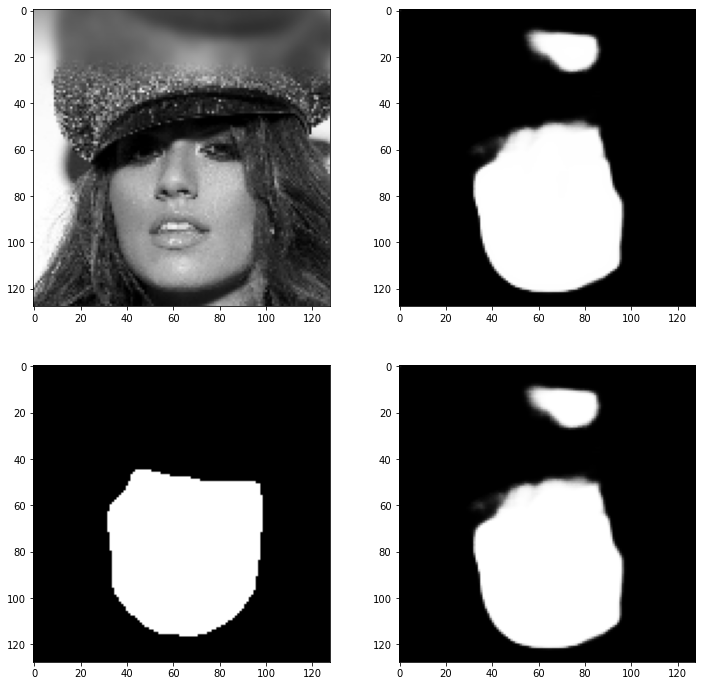

In [118]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
X_testProva = cv2.cvtColor(X_test[31],cv2.COLOR_BGR2RGB)
y_predProva = cv2.cvtColor(y_pred[31],cv2.COLOR_BGR2RGB)
axs[0,0].imshow(X_testProva)
axs[0,1].imshow(y_predProva)
axs[1,0].imshow(y_test[30],cmap="gray")
axs[1,1].imshow(y_pred[31],cmap="gray")

In [57]:
model.save('2KImages_unet_neck_300')


INFO:tensorflow:Assets written to: 2KImages_unet_neck_128\assets


In [ ]:
# load model for rgb
#model = keras.models.load_model('unetmodeltrained')


### Example 

In [136]:
X = []

path= 'test3.png'
#path="test3.png"
image = cv2.imread(path,0)
#image = image[120:120+420, 100:100+420]
image = cv2.resize(image, (128,128))
#,interpolation = cv2.INTER_AREA
X.append(image)
X.append(image)

X = np.array(X)
X.shape
y_pred=model.predict(X)

In [137]:
aaa = cv2.resize(y_pred[0].shape, (400,400))

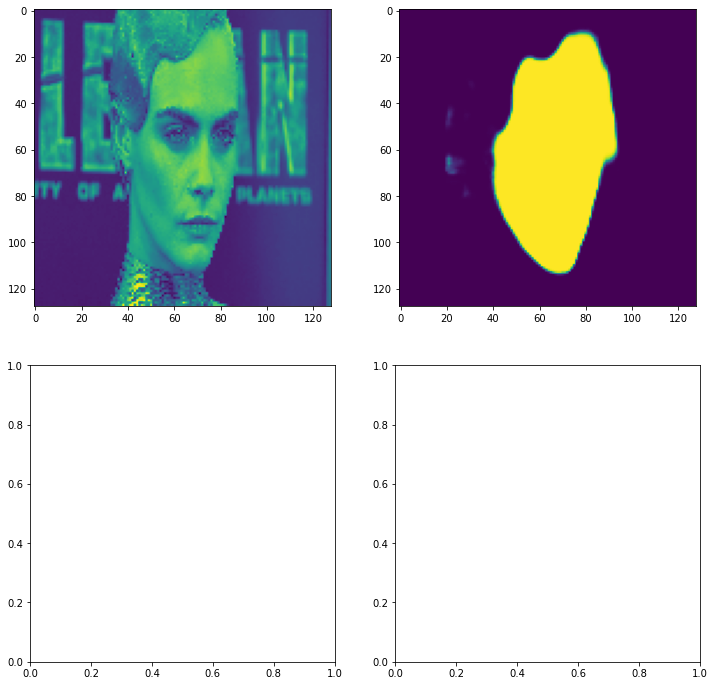

In [138]:
#path= 'test3.png'
path= 'test3.png'
image = cv2.imread(path,0)
image = cv2.resize(image, (128,128))
#image = image[120:120+420, 100:100+420]


fig, axs = plt.subplots(2, 2,figsize=(12,12))

axs[0,0].imshow(image)
axs[0,1].imshow(y_pred[0])


In [ ]:
plt.imshow(image)

In [ ]:
X = np.array(X)
X.shape

In [ ]:
y_pred=model.predict(X)

In [ ]:

#axs[1,0].imshow(X)
plt.imshow(y_pred[0])

### pose detection model


In [387]:
X = []

path= 'prova.png'
image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
image = cv2.imread(path, 0)
image = cv2.resize(image, (128,128),interpolation = cv2.INTER_AREA)
X.append(image)
X.append(image)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
X = np.array(X)
X.shape
y_pred=model.predict(X)

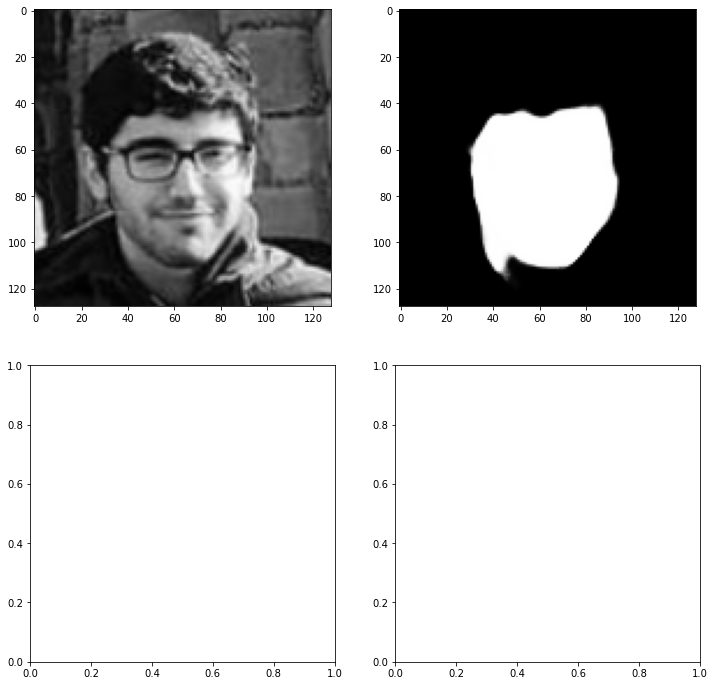

In [388]:
path= 'prova.png'
#image = cv2.imread(path,0)
#image = image[120:120+420, 100:100+420]
grey_y_pred = cv2.cvtColor(y_pred[0],cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(2, 2,figsize=(12,12))

axs[0,0].imshow(image)
axs[0,1].imshow(grey_y_pred)

In [287]:
from skimage import img_as_ubyte
Prova = img_as_ubyte(grey_y_pred)

In [333]:
mask = np.zeros(Prova.shape[:2], dtype=np.uint8)

In [313]:
ProvaMask = Prova.astype('uint8')

In [342]:
Lelelel = cv2.bitwise_and(image, image, mask = mask)

In [240]:
mask = np.zeros(grey_y_pred.shape, dtype='uint8')

In [369]:
mask_upload[0,0]

array([0, 0, 0], dtype=uint8)

In [395]:
Aveure = cv2.cvtColor(image*Prova,cv2.COLOR_BGR2RGB)

In [398]:
np.where(Aveure != 0, image, 0)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

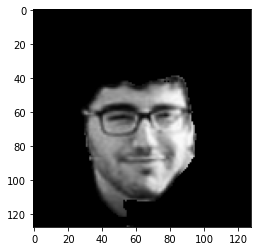

In [399]:
plt.imshow(np.where(Aveure != 0, image, 0))

In [ ]:
# segment style from style image
style1 = cv2.bitwise_and(image_style1,image_style1,mask = mask1)
style2 = cv2.bitwise_and(image_style2,image_style2,mask = mask2)
style3 = cv2.bitwise_and(image_style3,image_style3,mask = mask3)


# apply inverse mask to uploaded' image
upload_sgmt1 = cv2.bitwise_and(face_upload, face_upload, mask=255-mask1)
upload_sgmt2 = cv2.bitwise_and(face_upload, face_upload, mask=255-mask2)
upload_sgmt3 = cv2.bitwise_and(face_upload, face_upload, mask=255-mask3)


# combine the two masked images
result1 = cv2.add(style1, upload_sgmt1)
result2 = cv2.add(style2, upload_sgmt2)
result3 = cv2.add(style3, upload_sgmt3)
# change background to white
result1[result1[:,:,2]==0] = 255
result2[result2[:,:,2]==0] = 255
result3[result3[:,:,2]==0] = 255

cv2.imwrite('fusionstyle1.jpg', result1)
cv2.imwrite('fusionstyle2.jpg', result2)
cv2.imwrite('fusionstyle3.jpg', result3)